# Task 2
#### In this question you will implement and compare the following different KNN variants:
- ##### LSH
- ##### KD-Tree
- ##### Naive Version of KNN
Vary dataset size `N`, number of dimensions `D` to do training and testing time and memory comparison for finding K nearest neighbours. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage

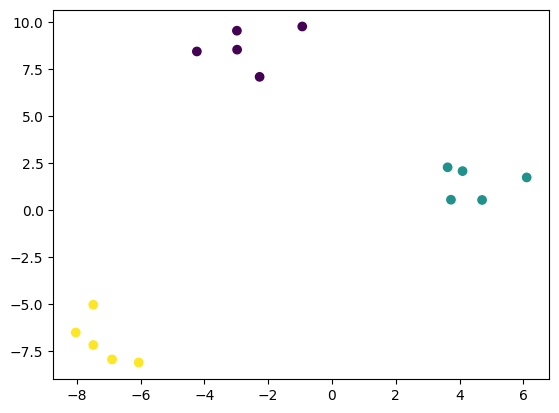

In [ ]:
n_features = 2

def generate_data(N, D, clusters=3):
    X, y = make_blobs(n_samples=N, centers=clusters, n_features=n_features, random_state=42)
    return X, y

def plot_data(matrix, labels):
    X = matrix[:, 0]
    Y = matrix[:, 1]
    plt.scatter(X, Y, c=labels)

rng = np.random.default_rng(0)

data, clusters = generate_data(N = 15, clusters=3, D=n_features)  # testing the function
plot_data(data, clusters)

### LSH 
Locality-sensitive hashing (LSH) is a method that hashes similar data points to have a high chance of being grouped together. This makes LSH a good way to optimize similarity search: by comparing the query data only with a subset of presumably similar items, you can avoid having to sort the entire dataset by some distance metric. The trade-off here is that there is no guarantee for correctness.

In [ ]:
def generate_hyperplanes(n, num_planes):
    H = rng.normal(size=(num_planes, n))  # hyperplanes as their normal vectors
    return H

planes = generate_hyperplanes(n_features, 3)

### Naive KNN

In [ ]:
def distance(x1 , x2):
    dist = np.sqrt(np.sum((x1-x2)**2))
    return dist

In [ ]:
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # compute the distance
        distances = [distance(x, x_train) for x_train in self.X_train]
    
        # get the closest k
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        print(k_nearest_labels)

        # majority vote
        label_counts = {}
        for label in k_nearest_labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        # Find the label with the highest count
        most_common_label = max(label_counts, key=label_counts.get)
        print("most_common_label =", most_common_label)
        
        return k_indices
        

In [ ]:
# Generate random data
np.random.seed(42)
X_train = np.random.rand(100, 2)
y_train = np.random.randint(0, 2, size=100)
X_test = np.array([[0.5, 0.5]])

X_train, y_train

(array([[0.37454012, 0.95071431],
        [0.73199394, 0.59865848],
        [0.15601864, 0.15599452],
        [0.05808361, 0.86617615],
        [0.60111501, 0.70807258],
        [0.02058449, 0.96990985],
        [0.83244264, 0.21233911],
        [0.18182497, 0.18340451],
        [0.30424224, 0.52475643],
        [0.43194502, 0.29122914],
        [0.61185289, 0.13949386],
        [0.29214465, 0.36636184],
        [0.45606998, 0.78517596],
        [0.19967378, 0.51423444],
        [0.59241457, 0.04645041],
        [0.60754485, 0.17052412],
        [0.06505159, 0.94888554],
        [0.96563203, 0.80839735],
        [0.30461377, 0.09767211],
        [0.68423303, 0.44015249],
        [0.12203823, 0.49517691],
        [0.03438852, 0.9093204 ],
        [0.25877998, 0.66252228],
        [0.31171108, 0.52006802],
        [0.54671028, 0.18485446],
        [0.96958463, 0.77513282],
        [0.93949894, 0.89482735],
        [0.59789998, 0.92187424],
        [0.0884925 , 0.19598286],
        [0.045

In [ ]:
# Parameters
k = 3

# Naive KNN
naive_knn = KNN(k)
start_time = time.time()
mem_usage = memory_usage((naive_knn.fit, (X_train, y_train)))
train_time_naive = time.time() - start_time
start_time = time.time()
y_hat = naive_knn.predict(X_test)[0]
test_time_naive = time.time() - start_time
print("Naive KNN predictions:", y_hat)
print("Train time of Naive KNN -", train_time_naive)
print("Test time of Naive KNN -", test_time_naive)
print("Memory usage of Naive KNN -", mem_usage)

[0, 1, 1]
most_common_label = 1
Naive KNN predictions: [48 73 81]
Train time of Naive KNN - 5.17852258682251
Test time of Naive KNN - 0.0010399818420410156
Memory usage of Naive KNN - [138.10546875, 138.10546875, 138.10546875]


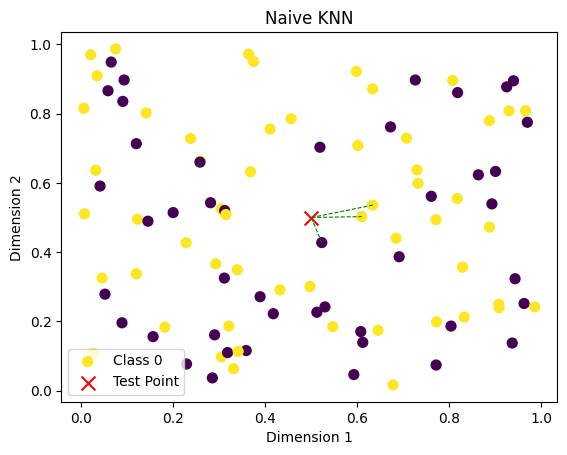

In [ ]:

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', s=50, label="Class 0")
plt.scatter(X_test[0, 0], X_test[0, 1], color='red', label='Test Point', marker='x', s=100)
plt.legend()

# Plot naive KNN neighbors
for idx in y_hat:
    plt.plot([X_test[0, 0], X_train[idx, 0]], [X_test[0, 1], X_train[idx, 1]], 'g--', linewidth=0.8, label='Naive KNN Neighbor' if idx == y_hat[0] else "")

plt.title("Naive KNN")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### KD Tree KNN

In [ ]:
class KDTreeNode:
    def __init__(self, point, label, left=None, right=None):
        self.point = point
        self.label = label
        self.left = left
        self.right = right

class KDTREEKNN:
    def __init__(self, k):
        self.k = k
        self.tree = None

    def fit(self, X, y):
        # Build the KD-tree
        points = list(zip(X, y))
        self.tree = self.build_kdtree(points)

    def build_kdtree(self, points, depth=0):
        n = len(points)
        if n <= 0:
            return None

        # Select axis based on depth so that axis cycles over all dimensions
        axis = depth % len(points[0][0])
        # Sort points by the selected axis and pick the median as pivot
        points.sort(key=lambda x: x[0][axis])
        median = n // 2

        # Create node and construct subtrees
        return KDTreeNode(
            point=points[median][0],
            label=points[median][1],
            left=self.build_kdtree(points[:median], depth + 1),
            right=self.build_kdtree(points[median + 1:], depth + 1)
        )

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

    def _predict(self, x):
        # Dictionary to store k nearest neighbors {distance: label}
        nearest_neighbors = {}
        
        # Recursive function to search the KD-tree
        def knn_search(node, depth=0):
            if node is None:
                return
            
            # Calculate distance between the point and the node's point
            dist = np.linalg.norm(x - node.point)
            
            # Update nearest neighbors dictionary
            if len(nearest_neighbors) < self.k:
                nearest_neighbors[dist] = node.label
            else:
                # If we have k neighbors, check if the current distance is smaller than the farthest neighbor
                max_dist = max(nearest_neighbors.keys())
                if dist < max_dist:
                    # Remove the farthest neighbor and add the current one
                    nearest_neighbors.pop(max_dist)
                    nearest_neighbors[dist] = node.label

            # Choose the axis based on depth
            axis = depth % len(x)
            # Determine whether to go left or right in the tree
            if x[axis] < node.point[axis]:
                knn_search(node.left, depth + 1)
                # Check if we need to search the other side
                if abs(x[axis] - node.point[axis]) < max(nearest_neighbors.keys()) or len(nearest_neighbors) < self.k:
                    knn_search(node.right, depth + 1)
            else:
                knn_search(node.right, depth + 1)
                # Check if we need to search the other side
                if abs(x[axis] - node.point[axis]) < max(nearest_neighbors.keys()) or len(nearest_neighbors) < self.k:
                    knn_search(node.left, depth + 1)
        
        # Start search from root
        knn_search(self.tree)
        
        # Return the labels of the k nearest neighbors
        return list(nearest_neighbors.values())

In [ ]:
# Parameters
k = 3

# KD KNN
KD_knn = KDTREEKNN(k)
start_time = time.time()
mem_usage = memory_usage((KD_knn.fit, (X_train, y_train)))
train_time_KD = time.time() - start_time
start_time = time.time()
y_hat = KD_knn.predict(X_test)[0]
test_time_KD = time.time() - start_time
print("KD KNN predictions:", y_hat)
print("Train time of KD KNN -", train_time_KD)
print("Test time of KD KNN -", test_time_KD)
print("Memory usage of KD KNN -", mem_usage)

KD KNN predictions: [1, 1, 0]
Train time of KD KNN - 2.8463425636291504
Test time of KD KNN - 0.0
Memory usage of KD KNN - [140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625, 140.22265625]
